# SHAP

## SHAP preprocess

In [1]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from interpret import show
import interpret.glassbox

pd.set_option('display.float_format', lambda x: '%.7f' % x)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
file_loc =  os.getcwd()
file_dir = ['/BPIC11/','/BPIC12/','/BPIC15/','/SEPSIS/']
file_tag = ['BPIC11','BPIC12','BPIC15','SEPSIS']
indep_var = ['Sequence', 'Event', 'Time', 'Models']
colors_bin = sns.color_palette("colorblind", len(file_dir))

In [2]:
def shap_val(df_c):
    X = df_c.loc[:,['Sequence', 'Event', 'Time', 'Models']]
    Y = df_c.AUC.values
    model = interpret.glassbox.ExplainableBoostingRegressor(interactions=0,random_state=42)
    model.fit(X, Y)
    explainer = shap.Explainer(model.predict,X)
    shap_values = explainer(X)
    return shap_values

In [3]:
def df_concat_maker(fd_):
    file_list = os.listdir(file_loc+str(fd_))
    df_list = []
    df_ = pd.DataFrame()

    for i in file_list:
        with open(file=(file_loc+str(fd_)+str(i)), mode='rb') as f:
            df =pickle.load(f)
        df=df[['Sequence', 'Event', 'Time', 'Models' ,'AUC']]
        df.columns = ['Sequence', 'Event', 'Time', 'Models','AUC']
        cate_map = {}
        col_co = 0
        for col in ['Sequence', 'Event', 'Time', 'Models']:
            df[col] = df[col].astype('category')
            cate_map[col] = {index+col_co: category for index, category in enumerate(df[col].cat.categories)}
            df[col] = df[col].cat.codes
            df[col] = df[col] + col_co
            col_co+= df[col].nunique()
        df_ = pd.concat([df_,df], sort=False)

    return df_,cate_map

In [4]:
shap_bin_abs = []
shap_bin_ = []
dfc_list = []
pre_cate = None
for fd in file_dir:
  df_concat,cate_dict = df_concat_maker(fd)
  df_concat = df_concat.drop_duplicates()
  shap_bin_abs.append(list(np.mean(np.abs(shap_val(df_concat).values),axis=0)))
  shap_bin_.append(shap_val(df_concat))
  if pre_cate is not None:
      if pre_cate == cate_dict:
          pass
      else:
          raise Exception("Dict is different")
          break
  pre_cate = cate_dict
  dfc_list.append(df_concat)
categorical = {}

for sub_dict in cate_dict.values():
    categorical.update(sub_dict)

In [5]:
print('BPIC11: ',len(shap_bin_[0]),'\nBPIC12: ', len(shap_bin_[1]),'\nBPIC15: ',len(shap_bin_[2]),'\nSEPSIS: ',len(shap_bin_[3]))

BPIC11:  108 
BPIC12:  108 
BPIC15:  108 
SEPSIS:  108


## Mean Abs SHAP

In [6]:
abs_dict = {}
abs_dict['BPIC11'] = shap_bin_abs[0]
abs_dict['BPIC12'] = shap_bin_abs[1]
abs_dict['BPIC15'] = shap_bin_abs[2]
abs_dict['SEPSIS'] = shap_bin_abs[3]
df_abs = pd.DataFrame(abs_dict, index=['SEQE', 'EE', 'TF', 'MOD'])
df_abs

,BPIC11,BPIC12,BPIC15,SEPSIS
SEQE,0.0309664,0.0430664,0.1199596,0.0692979
EE,0.0058859,0.0269484,0.0026356,0.0591570
TF,0.0045437,0.0035535,0.0121158,0.0058968
MOD,0.0083766,0.0035793,0.0196224,0.0044067


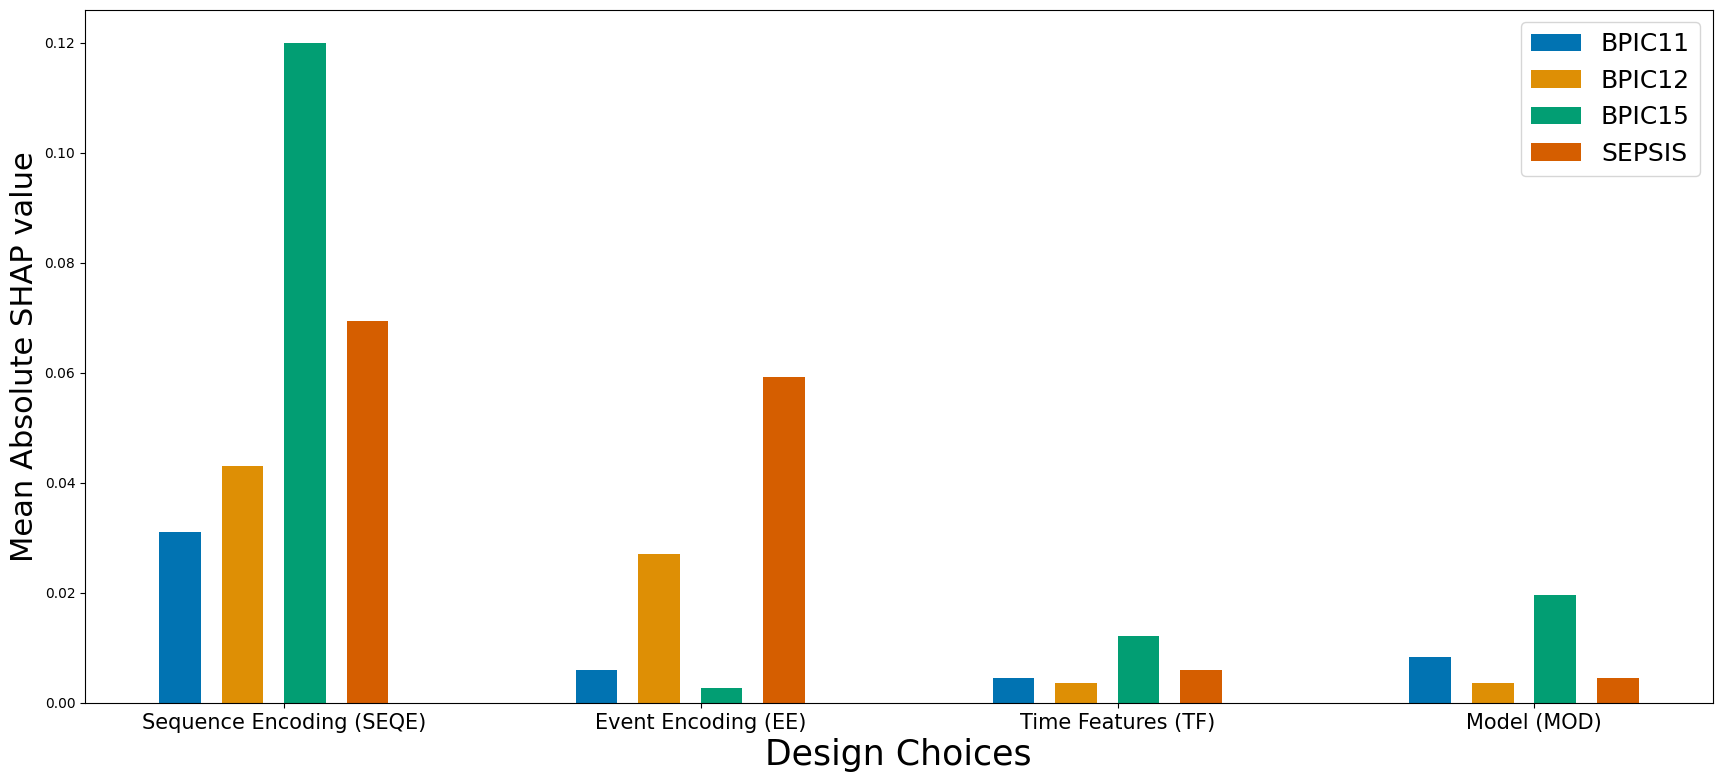

In [7]:
fig, ax = plt.subplots(figsize=(21,9))
bar_width = 0.1
col_name = ['Sequence Encoding (SEQE)', 'Event Encoding (EE)', 'Time Features (TF)', 'Model (MOD)']
index = np.arange(len(col_name))

for i in range(len(file_dir)):

    if i == 0:
        plt.bar(index + bar_width+0.1, shap_bin_abs[i], bar_width, alpha=1, color=colors_bin[i], label=file_tag[i])
    elif i==1:
        plt.bar(index + bar_width+0.25, shap_bin_abs[i], bar_width, alpha=1, color=colors_bin[i], label=file_tag[i])
    elif i==2:
        plt.bar(index + bar_width+0.4, shap_bin_abs[i], bar_width, alpha=1, color=colors_bin[i], label=file_tag[i])
    else:
        plt.bar(index + bar_width+0.55, shap_bin_abs[i], bar_width, alpha=1, color=colors_bin[i], label=file_tag[i])

plt.xticks(np.arange(bar_width+0.35, len(col_name)+ bar_width, 1), col_name,fontsize="15") # 4 or
plt.xlabel('Design Choices', size = 25)
plt.ylabel('Mean Absolute SHAP value', size = 22)
plt.legend(fontsize="18")
plt.show()

## SHAP value for individual 

In [8]:
shap_data_bin = []
for sl in shap_bin_:
    shap_by_log = {}
    for sb,dt in zip(sl.values, sl.data):
        for idx,(s,d) in enumerate(zip(sb,dt)):
            if idx == 4:
                if f'NoLayer: {d}' not in shap_by_log:
                    shap_by_log[f'NoLayer: {d}'] = s
                else:
                    if round(shap_by_log[f'NoLayer: {d}'],6) != round(s,6):
                        raise Exception("Value not matched")
            elif idx == 5:
                if f'NoLayer: {d}' not in shap_by_log:
                    shap_by_log[f'NoHidden: {d}'] = s
                else:
                    if round(shap_by_log[f'NoHidden: {d}'],6) != round(s,6):
                        raise Exception("Value not matched")
            else:
                if categorical[d] not in shap_by_log:
                    shap_by_log[categorical[d]] = s
                else:
                    if round(shap_by_log[categorical[d]],6) != round(s,6):
                        raise Exception("Value not matched")
    num_uniq = 0
    for i in range(sl.data.shape[1]):
        num_uniq+= np.unique(sl.data[:,i]).shape[0]
    if num_uniq != len(shap_by_log.keys()):
        raise Exception("Dict key not matched")
    shap_data_bin.append(shap_by_log)


In [9]:
df_bpic11 = pd.DataFrame(shap_data_bin[0], index=['BPIC11']).T
df_bpic12 = pd.DataFrame(shap_data_bin[1], index=['BPIC12']).T
df_bpic15 = pd.DataFrame(shap_data_bin[2], index=['BPIC15']).T
df_sepsis = pd.DataFrame(shap_data_bin[3], index=['SEPSIS']).T

df_combined = pd.concat([df_bpic11, df_bpic12, df_bpic15, df_sepsis], axis=1)
new_index_order = [
    'cont', 'prfx', 'se', 'oh', 'frq', 'all', 'tssc_tsp', 'none',
    'dt', 'rf', 'xgb', 'adb', 'mlp', 'lstm']
df_combined = df_combined.reindex(new_index_order)
df_combined.index = ['SEQE: CO','SEQE: PP','SEQE: SE','EE: OH','EE: FB',
                     'TF: ALL','TF: TST','TF: NONE','MOD: DT','MOD: RF',
                    'MOD: XGB','MOD: ADB','MOD: MLP','MOD: LSTM']
df_combined

,BPIC11,BPIC12,BPIC15,SEPSIS
SEQE: CO,-0.0064769,-0.0246263,-0.0559981,-0.0423273
SEQE: PP,0.0478572,0.0665572,0.1853922,0.1070968
SEQE: SE,-0.0385651,-0.0380158,-0.1184887,-0.0584697
EE: OH,0.0058859,0.0269484,-0.0026356,0.0591570
EE: FB,-0.0058859,-0.0269484,0.0026356,-0.0591570
TF: ALL,-0.0064432,0.0041626,-0.0176846,-0.0087031
TF: TST,0.0062935,0.0011575,0.0051899,0.0003192
TF: NONE,0.0008945,-0.0053404,0.0134728,0.0086680
MOD: DT,-0.0135512,-0.0052181,-0.0200573,0.0016074
MOD: RF,0.0076867,0.0061689,0.0054096,0.0077485


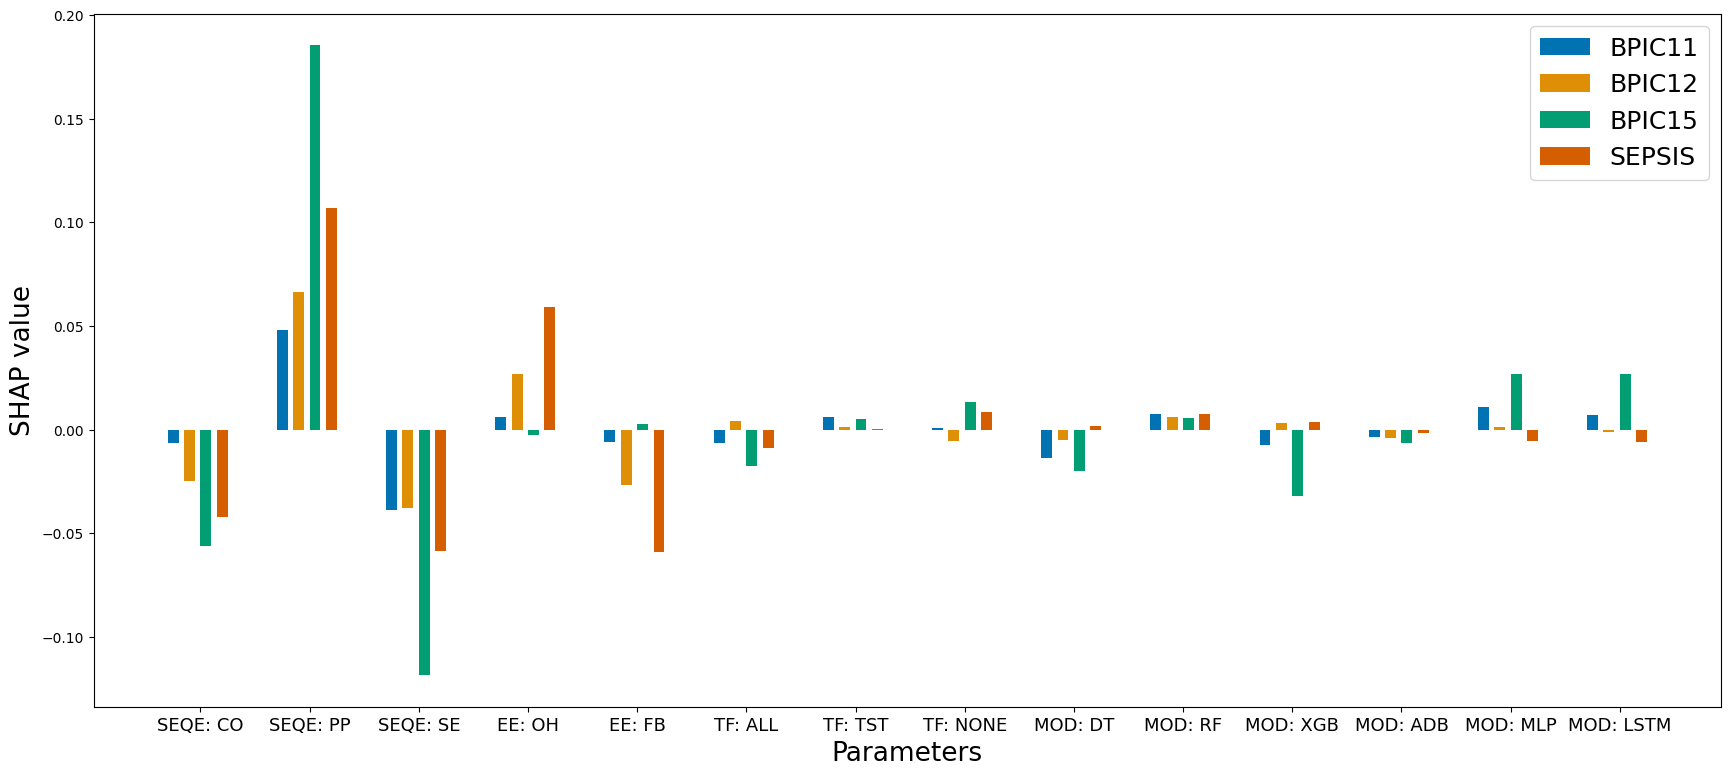

In [10]:
fig, ax = plt.subplots(figsize=(21,9))
bar_width = 0.1
index = np.arange(len(df_combined.index.tolist()))

for i in range(len(file_dir)):

    if i == 0:
        plt.bar(index + bar_width+0.1, df_combined.values[:,i], bar_width, alpha=1, color=colors_bin[i], label=file_tag[i])
    elif i==1:
        plt.bar(index + bar_width+0.25, df_combined.values[:,i], bar_width, alpha=1, color=colors_bin[i], label=file_tag[i])
    elif i==2:
        plt.bar(index + bar_width+0.4, df_combined.values[:,i], bar_width, alpha=1, color=colors_bin[i], label=file_tag[i])
    else:
        plt.bar(index + bar_width+0.55, df_combined.values[:,i], bar_width, alpha=1, color=colors_bin[i], label=file_tag[i])

plt.xticks(np.arange(bar_width+0.35, len(df_combined)+ bar_width, 1), df_combined.index.tolist(),fontsize="13") # 16 if nextact
plt.xlabel('Parameters', size = 19)
plt.ylabel('SHAP value', size = 19)
plt.legend(fontsize="18")
plt.show()

# EBM

## EBM preprocess

In [11]:

def df_concat_ebm(fd_):
    file_list = os.listdir(file_loc+str(fd_))
    df_list = []
    df_ = pd.DataFrame()

    for i in file_list:
        with open(file=(file_loc+str(fd_)+str(i)), mode='rb') as f:
            df =pickle.load(f)
        df=df[['Sequence', 'Event', 'Time', 'Models','AUC']]
        df.columns = ['Sequence', 'Event', 'Time', 'Models','AUC']
        df_ = pd.concat([df_,df], sort=False)
    df_.columns = ['SEQE', 'EE', 'TF', 'MOD','AUC']
    return df_

In [12]:
def ebmout(df_c):
  X = df_c.iloc[:,:-1]
  Y = df_c.iloc[:,-1]
  feature_types=['nominal','nominal','nominal','nominal']
  model = interpret.glassbox.ExplainableBoostingRegressor(interactions=45,random_state=42,feature_types=feature_types)
  model.fit(X, Y)
  return model

In [13]:
dfc_ebm_1 = []
value_mappings = {
    'cont': 'CO', 'prfx': 'PP', 'se': 'SE', 'oh': 'OH',
    'frq': 'FB', 'all': 'ALL', 'tssc_tsp': 'TST', 'none': 'NONE',
    'dt' : 'DT', 'rf':'RF', 'xgb':'XGB','adb':'ADB',
    'lstm': 'LSTM', 'mlp': 'MLP'
}

for fd in file_dir:
    df_concat = df_concat_ebm(fd)
    df_concat = df_concat.drop_duplicates()
    df_concat = df_concat.replace(value_mappings)
    dfc_ebm_1.append(df_concat)


## EBM Global term importance

In [14]:
glob_imp_bin = {}
sing_imp_bin = {}
inter_imp_bin = {}
for el,tag in zip(dfc_ebm_1,file_tag):
    ebm_model = ebmout(el)
    exp_glob = ebm_model.explain_global()
    glob_importance = {}
    sing_importance = {}
    inter_importance = {}
    for n,s in zip(exp_glob.data()['names'],exp_glob.data()['scores']):
        glob_importance[n] = s
    glob_imp_bin[tag] = glob_importance
    for fi in range(4):
        for n,s in zip(exp_glob.data(fi)['names'],exp_glob.data(fi)['scores']):
            sing_importance[n] = s
    sing_imp_bin[tag] = sing_importance
    for fi in range(4,len(exp_glob.data()['names'])):
        for i,ln in enumerate(exp_glob.data(fi)['left_names']):
            for j,rn in enumerate(exp_glob.data(fi)['right_names']):
                inter_importance[ln+"& "+rn] = exp_glob.data(fi)['scores'][i,j]
    inter_imp_bin[tag] = inter_importance

In [15]:
pd.DataFrame(glob_imp_bin)

,BPIC11,BPIC12,BPIC15,SEPSIS
SEQE,0.0312792,0.0435014,0.1211713,0.0699979
EE,0.0058859,0.0269484,0.0026356,0.0591570
TF,0.0044610,0.0035558,0.0120071,0.0058652
MOD,0.0083766,0.0035793,0.0196224,0.0044067
SEQE & EE,0.0072864,0.0443527,0.0107427,0.0933136
SEQE & TF,0.0041918,0.0057411,0.0027550,0.0073748
SEQE & MOD,0.0022533,0.0031864,0.0043054,0.0051571
EE & TF,0.0008359,0.0015338,0.0019484,0.0035987
EE & MOD,0.0013962,0.0030783,0.0021235,0.0054250
TF & MOD,0.0028052,0.0016969,0.0030947,0.0071473


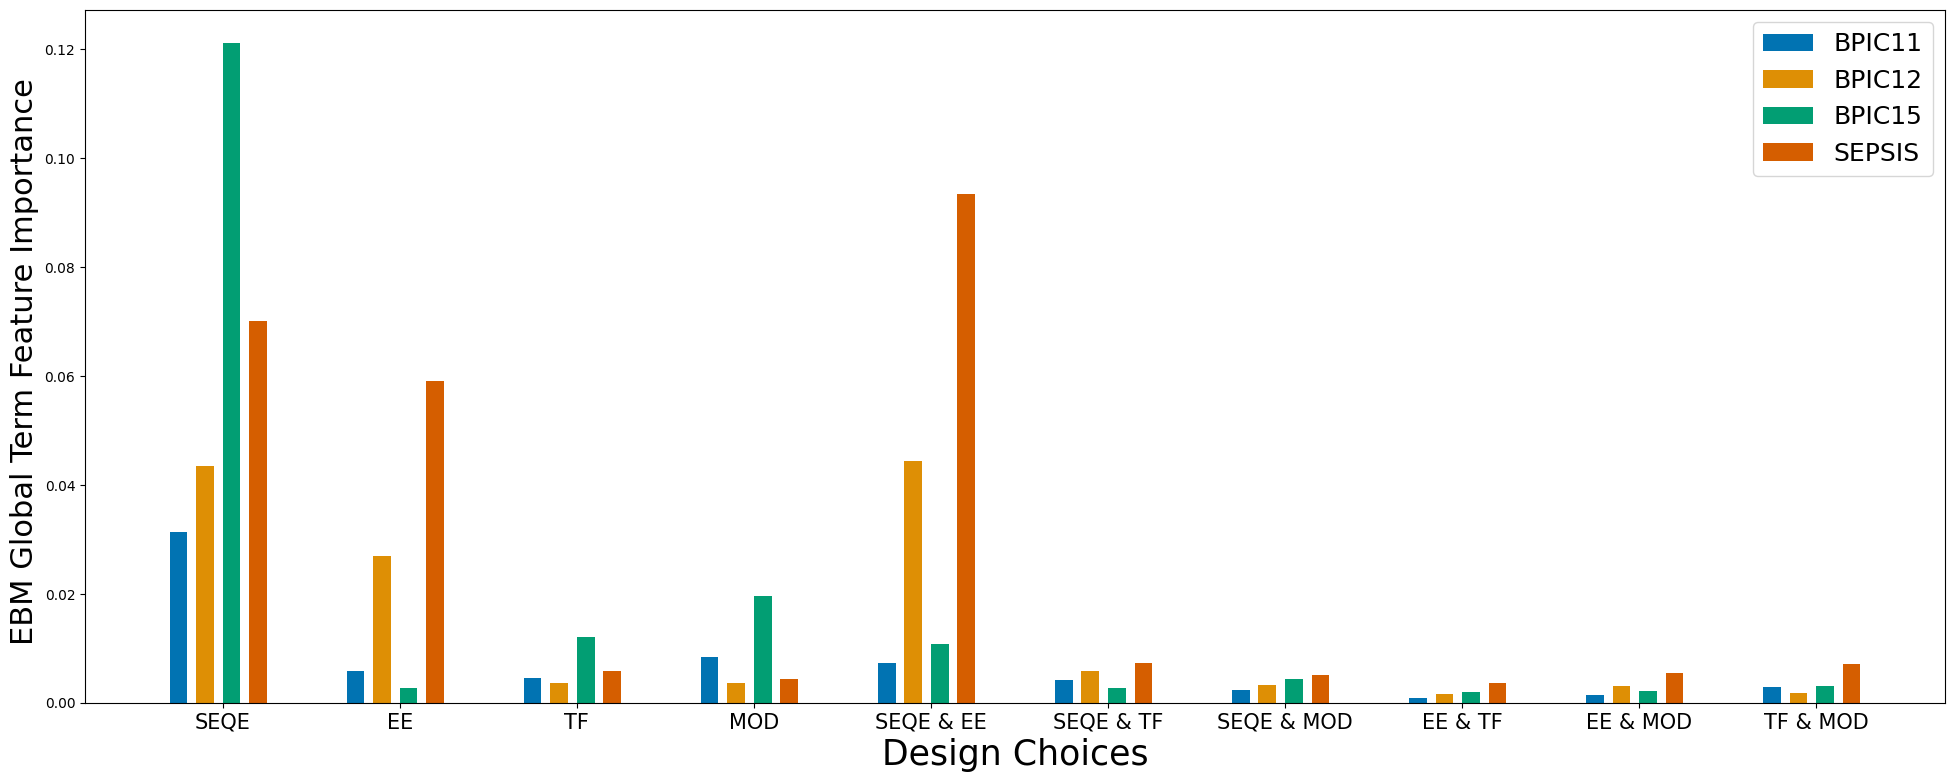

In [16]:
fig, ax = plt.subplots(figsize=(24,9))
bar_width = 0.1
ebm_glob_graph = [list(i.values()) for i in list(glob_imp_bin.values())]
col_name = pd.DataFrame(glob_imp_bin).index.tolist()
index = np.arange(len(col_name))

for i in range(len(file_dir)):

    if i == 0:
        plt.bar(index + bar_width+0.1, ebm_glob_graph[i], bar_width, alpha=1, color=colors_bin[i], label=file_tag[i])
    elif i==1:
        plt.bar(index + bar_width+0.25, ebm_glob_graph[i], bar_width, alpha=1, color=colors_bin[i], label=file_tag[i])
    elif i==2:
        plt.bar(index + bar_width+0.4, ebm_glob_graph[i], bar_width, alpha=1, color=colors_bin[i], label=file_tag[i])
    else:
        plt.bar(index + bar_width+0.55, ebm_glob_graph[i], bar_width, alpha=1, color=colors_bin[i], label=file_tag[i])

plt.xticks(np.arange(bar_width+0.35, len(col_name)+ bar_width, 1), col_name,fontsize="15") # 4 or
plt.xlabel('Design Choices', size = 25)
plt.ylabel('EBM Global Term Feature Importance ', size = 22)
plt.legend(fontsize="18")
plt.show()

## EBM Individual Term

In [17]:
pd.DataFrame(sing_imp_bin)

,BPIC11,BPIC12,BPIC15,SEPSIS
CO,-0.0074153,-0.0259314,-0.0596332,-0.0444273
PP,0.0469188,0.0652522,0.1817570,0.1049968
SE,-0.0395035,-0.0393208,-0.1221238,-0.0605696
FB,-0.0058859,-0.0269484,0.0026356,-0.0591570
OH,0.0058859,0.0269484,-0.0026356,0.0591570
ALL,-0.0066914,0.0041693,-0.0180107,-0.0087978
NONE,0.0006462,-0.0053336,0.0131468,0.0085733
TST,0.0060452,0.0011643,0.0048639,0.0002245
ADB,-0.0037382,-0.0042544,-0.0066910,-0.0016939
DT,-0.0136826,-0.0052746,-0.0201373,0.0016586


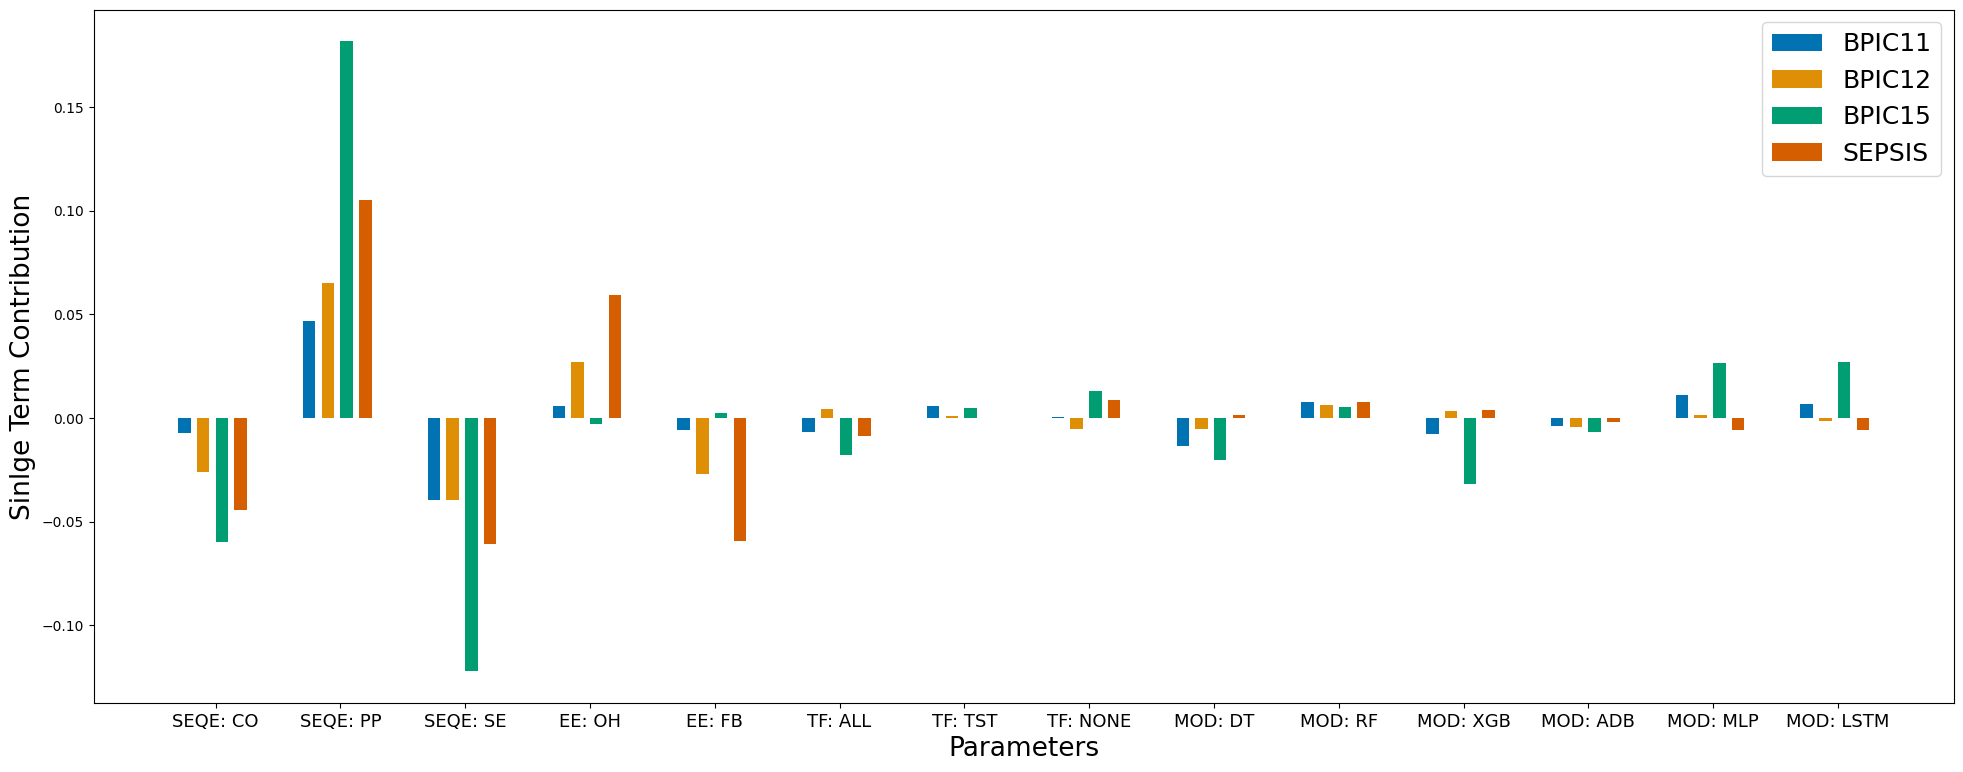

In [18]:
fig, ax = plt.subplots(figsize=(24,9))
bar_width = 0.1
index = np.arange(len(df_combined.index.tolist()))
ebm_sing_graph = pd.DataFrame(sing_imp_bin)#[list(i.values())[:7] for i in list(sing_imp_bin.values())]
new_idx_order = ['CO','PP','SE','OH','FB','ALL','TST','NONE','DT','RF','XGB','ADB','MLP','LSTM']
ebm_sing_graph = ebm_sing_graph.reindex(new_idx_order)
ebm_sing_graph.index = ['SEQE: CO','SEQE: PP','SEQE: SE','EE: OH','EE: FB',
                     'TF: ALL','TF: TST','TF: NONE','MOD: DT','MOD: RF',
                    'MOD: XGB','MOD: ADB','MOD: MLP','MOD: LSTM']
for i in range(len(file_dir)):

    if i == 0:
        plt.bar(index + bar_width+0.1, ebm_sing_graph.values[:,i], bar_width, alpha=1, color=colors_bin[i], label=file_tag[i])
    elif i==1:
        plt.bar(index + bar_width+0.25, ebm_sing_graph.values[:,i], bar_width, alpha=1, color=colors_bin[i], label=file_tag[i])
    elif i==2:
        plt.bar(index + bar_width+0.4, ebm_sing_graph.values[:,i], bar_width, alpha=1, color=colors_bin[i], label=file_tag[i])
    else:
        plt.bar(index + bar_width+0.55, ebm_sing_graph.values[:,i], bar_width, alpha=1, color=colors_bin[i], label=file_tag[i])

plt.xticks(np.arange(bar_width+0.35, len(ebm_sing_graph)+ bar_width, 1), ebm_sing_graph.index.tolist(),fontsize="13") # 16 if nextact
plt.xlabel('Parameters', size = 19)
plt.ylabel('Sinlge Term Contribution', size = 19)
plt.legend(fontsize="18")
plt.show()

## EBM Pair-wise Interaction Contribution

In [19]:
pd.DataFrame(inter_imp_bin)

,BPIC11,BPIC12,BPIC15,SEPSIS
CO& FB,0.0078282,0.0286576,0.0147817,0.0604209
CO& OH,-0.0082893,-0.0346254,-0.0165948,-0.0707222
PP& FB,-0.0104540,-0.0666689,-0.0108829,-0.1420055
PP& OH,0.0124860,0.0755076,0.0135622,0.1589438
SE& FB,0.0015448,0.0288928,-0.0047506,0.0605761
SE& OH,-0.0031157,-0.0317637,0.0038843,-0.0672132
CO& ALL,-0.0020652,-0.0035395,-0.0021798,-0.0063621
CO& NONE,0.0048034,0.0049969,0.0001379,0.0052749
CO& TST,-0.0026909,-0.0026840,0.0017149,-0.0022442
PP& ALL,-0.0001672,-0.0009375,0.0076214,-0.0001197
